<a href="https://colab.research.google.com/github/Mahsa-Goudarzi/ComputerVision/blob/main/M3_Image%20Classification/Exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODULE 3: IMAGE CLASSIFICATION



# **EXERCISE 4**

Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Generate synthetic image with random blobs

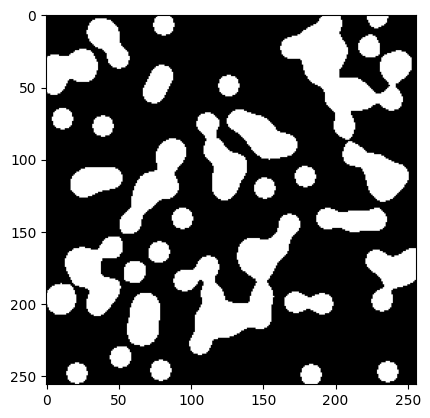

In [1]:
import matplotlib.pyplot as plt
from skimage.data import binary_blobs

# Generate binary blobs image
image = binary_blobs(length=256, volume_fraction=0.3, rng=42)

plt.imshow(image, cmap='gray')
plt.show()

# 2. Object segmentation and labeling

- Segmentation of blobs using Otsu's optimal threshold
- Labeling connected regions
- Visualization



/usr/local/lib/python3.11/dist-packages/skimage/exposure/exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


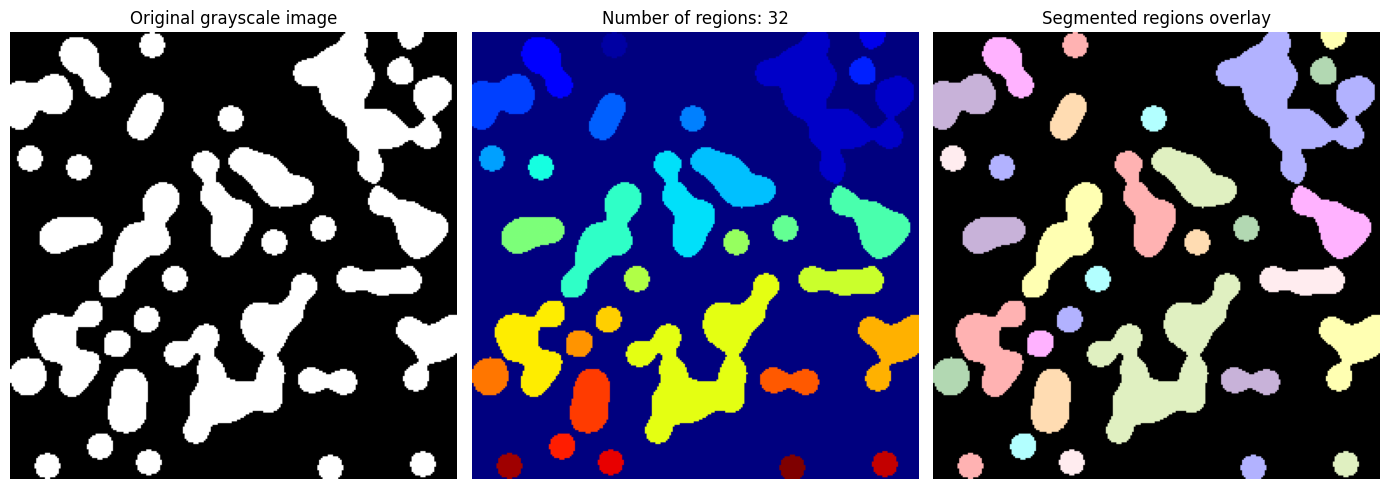

In [2]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

thresh = threshold_otsu(image)
bw = image > thresh # keep lighter regions with grayscale intensities above threshold

# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=image)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(image,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

# 3. Get regional properties in a pandas dataframe

Function documentation with a list of available attributes can be found at https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table


In [3]:
from skimage.measure import regionprops
import pandas as pd
from skimage import measure

properties = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent','axis_major_length'])

df_features = pd.DataFrame(properties)
df_features.head()

,label,area,eccentricity,extent,axis_major_length
0,1,169.0,0.000000,0.751111,14.679213
1,2,2977.0,0.755218,0.376026,98.161559
2,3,116.0,0.736219,0.773333,15.175575
3,4,594.0,0.885234,0.565714,41.613720
4,5,191.0,0.343427,0.795833,16.139289


Represent area of the blobs as a function of the major axis length

<Axes: xlabel='axis_major_length', ylabel='area'>

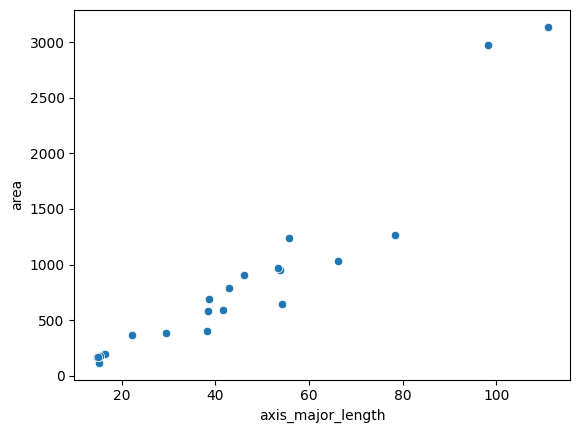

In [4]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

Clear correlation between blob's length and area can be observed

#4. Analyze blobs


Since you have the feature data in a pandas dataframe, you can exploit all the functions of te libraries. For instance:

How many blobs have an area above the average?

,label,area,eccentricity,extent,axis_major_length
0,1,1746.0,0.839126,0.531345,79.706580
4,5,1390.0,0.771610,0.636738,59.190600
7,8,631.0,0.879866,0.562389,41.846949
16,17,2327.0,0.789345,0.559644,74.420603
19,20,921.0,0.931595,0.501634,59.456784
22,23,627.0,0.959253,0.398095,57.490670
26,27,843.0,0.934077,0.468333,56.093055
30,31,2233.0,0.902812,0.448034,99.373752
31,32,595.0,0.883335,0.502534,44.550650
32,33,2401.0,0.909286,0.445455,117.895047


there are 10 blobs with an area larger or equal the mean area 578.2647058823529


Represent the blobs that have an area smaller than the average blob's area

there are 24 blobs with an area smaller than the mean area 578.2647058823529


find the labels of small and large blobs

labels of small blobs: [ 2  3  4  6  7  9 10 11 12 13 14 15 16 18 19 21 22 24 25 26 28 29 30 34]
labels of large blobs: [ 1  5  8 17 20 23 27 31 32 33]


Create a binary mask with the large and small blobs

Represent the large and small blobs

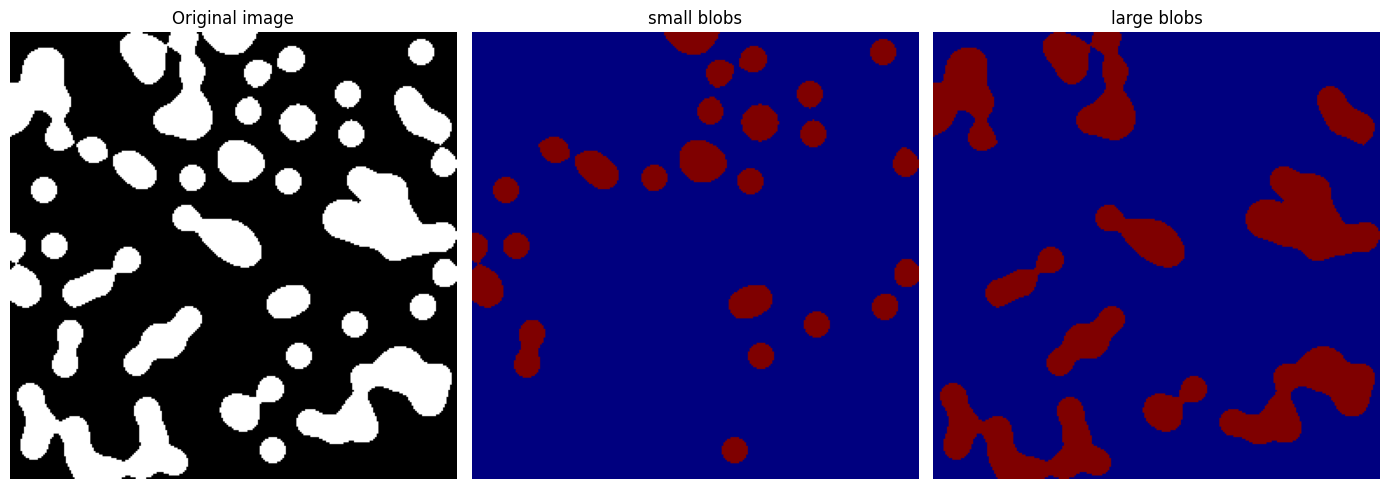

#5. Obtain texture-based regional properties

For the original image

[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 44673
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 965
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 0
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,3529.582816,13.841501,0.945720,0.673245,0.890433
1,3711.104218,14.553350,0.942929,0.756179,0.847556
2,6192.857143,24.285714,0.904763,0.785758,0.678703
3,5780.000000,22.666667,0.911112,0.788021,0.701750
4,3520.656780,13.806497,0.945858,0.701288,0.881521
5,5960.625000,23.375000,0.908335,0.766078,0.722105
6,6386.383929,25.044643,0.901787,0.754742,0.712653
7,3406.640625,13.359375,0.947611,0.679395,0.892815
8,6386.383929,25.044643,0.901787,0.764893,0.699072
9,5489.123377,21.525974,0.915586,0.738617,0.776178
